# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений и не только.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## OpenCV
Библиотека для удобной работы с картинками

## Загрузка изображения

Загрузим изображение из интернета, например, мем про юккури.

In [2]:
! wget "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg" -O mona_lisa.jpg

--2024-11-11 09:13:56--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31371 (31K) [image/jpeg]
Saving to: ‘mona_lisa.jpg’

mona_lisa.jpg       100%[===================>]  30.64K  --.-KB/s    in 0.04s   

2024-11-11 09:13:56 (747 KB/s) - ‘mona_lisa.jpg’ saved [31371/31371]



## Чтение изображения

In [3]:
img = Image.open('./mona_lisa.jpg')

In [4]:
img.format

'JPEG'

In [5]:
img.show()

In [6]:
img.size

(270, 402)

In [7]:
img.mode

'RGB'

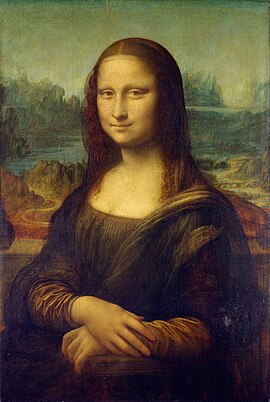

In [8]:
img

## Матричное представление

In [9]:
img_matrix = np.array(img)

In [10]:
img_matrix.shape

(402, 270, 3)

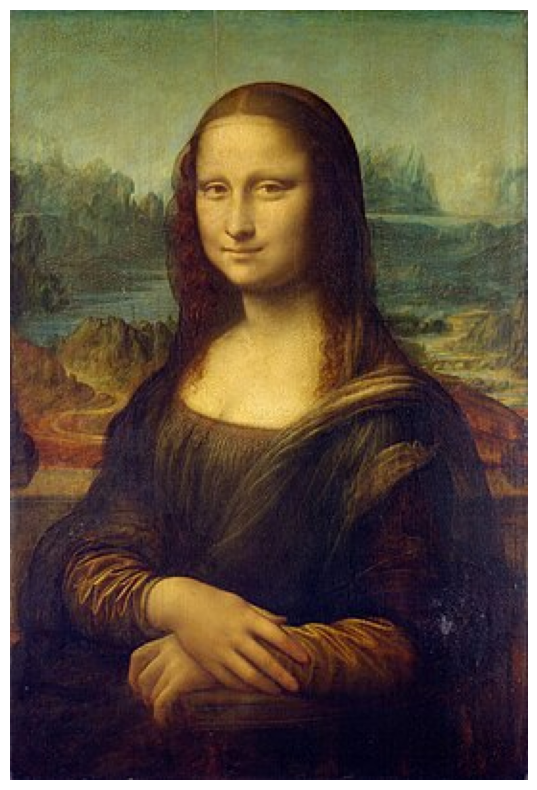

In [11]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)
plt.axis('off')
plt.show()

In [12]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

#### Математическая формула свертки:
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)


#### Формула свертки в торче:
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k), $$

Где:
- $\star$ - оператор кросс-корреляции (*почти*-свертка),
- $N$ - размер батча
- $C$ - количество каналов (входных и выхолных),
- $H$ - высота тензора в пикселях
- $W$ - ширина тензора в пикселях

#### Как рассчитываются итоговые шейпы:
$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$



- [Калькудятор расчета свертки](https://madebyollin.github.io/convnet-calculator/) (не тестил для всех возможных сценариев)
- https://www.youtube.com/@animatedai - У чувака красивые ролики про свертки и не только
- [Convolution explainer](https://poloclub.github.io/cnn-explainer/)


In [14]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
)

In [15]:
conv1.weight

Parameter containing:
tensor([[[[-0.0501, -0.1284, -0.0649],
          [ 0.0640, -0.1809, -0.1624],
          [ 0.1422, -0.1187,  0.1766]],

         [[ 0.0411, -0.0849,  0.0247],
          [ 0.0033, -0.0750, -0.0737],
          [-0.0200,  0.0691,  0.1434]],

         [[-0.0386,  0.1093, -0.1850],
          [ 0.1882, -0.1472, -0.1635],
          [-0.0909,  0.0172,  0.1328]]],


        [[[-0.0318, -0.1494, -0.1906],
          [ 0.0197,  0.1041, -0.1890],
          [-0.1129, -0.0577, -0.0781]],

         [[ 0.0482,  0.1830, -0.1040],
          [ 0.1662,  0.0731,  0.0350],
          [-0.1786, -0.0853, -0.0630]],

         [[-0.0554, -0.0798,  0.0412],
          [ 0.1879, -0.0037, -0.1852],
          [-0.1444, -0.1259, -0.0135]]],


        [[[ 0.0098, -0.0571,  0.1431],
          [ 0.1279, -0.0711, -0.1677],
          [-0.0730,  0.1643,  0.0192]],

         [[ 0.0703, -0.1226, -0.0244],
          [ 0.1797,  0.1552,  0.0154],
          [-0.0645, -0.1392,  0.0912]],

         [[ 0.1145, -0

In [16]:
conv1.weight.shape

torch.Size([10, 3, 3, 3])

In [17]:
conv1.bias.shape

torch.Size([10])

In [18]:
list(conv1.parameters())

[Parameter containing:
 tensor([[[[-0.0501, -0.1284, -0.0649],
           [ 0.0640, -0.1809, -0.1624],
           [ 0.1422, -0.1187,  0.1766]],
 
          [[ 0.0411, -0.0849,  0.0247],
           [ 0.0033, -0.0750, -0.0737],
           [-0.0200,  0.0691,  0.1434]],
 
          [[-0.0386,  0.1093, -0.1850],
           [ 0.1882, -0.1472, -0.1635],
           [-0.0909,  0.0172,  0.1328]]],
 
 
         [[[-0.0318, -0.1494, -0.1906],
           [ 0.0197,  0.1041, -0.1890],
           [-0.1129, -0.0577, -0.0781]],
 
          [[ 0.0482,  0.1830, -0.1040],
           [ 0.1662,  0.0731,  0.0350],
           [-0.1786, -0.0853, -0.0630]],
 
          [[-0.0554, -0.0798,  0.0412],
           [ 0.1879, -0.0037, -0.1852],
           [-0.1444, -0.1259, -0.0135]]],
 
 
         [[[ 0.0098, -0.0571,  0.1431],
           [ 0.1279, -0.0711, -0.1677],
           [-0.0730,  0.1643,  0.0192]],
 
          [[ 0.0703, -0.1226, -0.0244],
           [ 0.1797,  0.1552,  0.0154],
           [-0.0645, -0.1392, 

Одна из операций самых нужных трансформаций - переход к устоявшемуся тензорному представлению изображения в торче:

$$H \times W \times C \to C \times H \times W$$
$$[0, 255] \to [0, 1]$$


Ее осуществляет `T.ToTensor`:

In [19]:
?T.ToTensor

In [20]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [21]:
transform =  T.ToTensor()
img_tensor = transform(img).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 402, 270])

In [22]:
img_tensor.shape

torch.Size([1, 3, 402, 270])

In [23]:
output = conv1(img_tensor)

In [24]:
img_tensor.shape

torch.Size([1, 3, 402, 270])

In [25]:
output.shape

torch.Size([1, 10, 400, 268])

In [26]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding="same", # == 1
)

In [27]:
output = conv2(img_tensor)

In [28]:
output.shape

torch.Size([1, 10, 402, 270])

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [29]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [30]:
img_tensor

tensor([[[5., 6., 0., 9., 7., 2., 5., 4., 9., 0.],
         [2., 0., 0., 9., 8., 2., 7., 8., 0., 8.],
         [3., 4., 6., 6., 2., 4., 6., 9., 5., 2.],
         [2., 5., 7., 5., 7., 2., 0., 4., 4., 3.],
         [4., 9., 3., 1., 2., 7., 4., 7., 8., 8.],
         [3., 4., 3., 3., 7., 6., 8., 1., 6., 9.],
         [0., 0., 9., 5., 9., 7., 2., 8., 6., 5.],
         [9., 0., 6., 4., 7., 8., 6., 8., 0., 1.],
         [2., 0., 9., 8., 1., 5., 2., 0., 3., 7.],
         [7., 5., 6., 1., 0., 7., 2., 5., 2., 5.]]])

In [31]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [32]:
pooling1(img_tensor)

tensor([[[6., 9., 8., 8., 9.],
         [5., 7., 7., 9., 5.],
         [9., 3., 7., 8., 9.],
         [9., 9., 9., 8., 6.],
         [7., 9., 7., 5., 7.]]])

In [33]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [34]:
pooling2(img_tensor)

tensor([[[3.2500, 4.5000, 4.7500, 6.0000, 4.2500],
         [3.5000, 6.0000, 3.7500, 4.7500, 3.5000],
         [5.0000, 2.5000, 5.5000, 5.0000, 7.7500],
         [2.2500, 6.0000, 7.7500, 6.0000, 3.0000],
         [3.5000, 6.0000, 3.2500, 2.2500, 4.2500]]])

## Датасет MNIST

In [35]:
mnist_train = MNIST(
    "./mnist",
    train=False,
    download=True
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.1MB/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.94MB/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [36]:
mnist_train.data.shape

torch.Size([10000, 28, 28])

In [37]:
mnist_train.test_labels.shape

torch.Size([10000])

In [38]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 7)

In [39]:
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, *args, transform=None, **kwargs):
#         ...
#         self.transform = transform

#     def __getitem__(self, idx: int):
#         element = self.data[idx]
#         if self.transform is not None:
#             element = self.transform(element)
#         return element

In [40]:
mnist_train = MNIST(
    "./mnist",
    train=True,
    download=True,
    transform=T.Compose(
        [T.ToTensor(),
         T.Resize(28)]
    )
)

In [41]:
mnist_valid = MNIST(
    "./mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

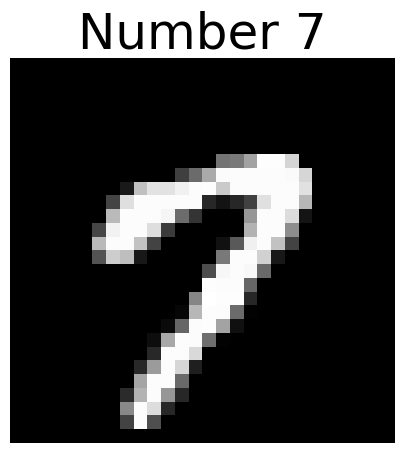

In [42]:
plt.figure(figsize=(5, 5))
plt.title(f'Number {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0], cmap='grey')
plt.axis("off")
plt.show()

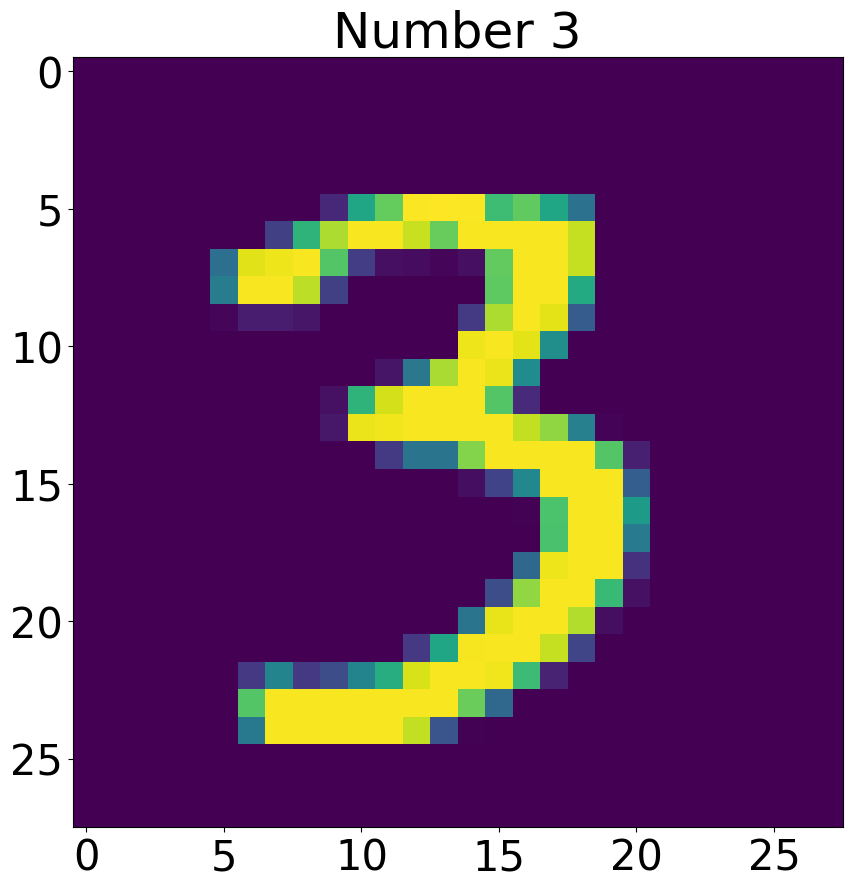

In [43]:
plt.figure(figsize=(10, 10))
plt.title(f'Number {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

In [44]:
len(mnist_train)

60000

In [45]:
len(mnist_valid)

10000

In [46]:
train_loader = DataLoader(mnist_train, batch_size=1024, shuffle=True, num_workers=12)
valid_loader = DataLoader(mnist_valid, batch_size=1024, shuffle=False, num_workers=12)

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [47]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [48]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x.to(DEVICE))

        loss = loss_fn(output, y.to(DEVICE))

        train_loss += loss.detach()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss.item()

In [49]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        y = y.to(DEVICE)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.detach()

        y_pred = torch.argmax(output, -1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss.item(), accuracy

In [55]:
def plot_stats(
    train_loss,
    valid_loss,
    valid_accuracy,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' valid accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [51]:
def get_number_of_model_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

In [52]:
class CustomSequential(nn.Sequential):
    def __init__(self, *layers):
        super().__init__(*layers)
        self._num_params = get_number_of_model_parameters(self)

        self.to(DEVICE)

        print(self)

    def __str__(self):
        return f"{'*'*75}\nModel:\n{self.__repr__()}\n\nNumber of parameters: {self._num_params}\n{'*'*75}"

    def forward(self, x):
        """
        This wrapper allows us to forget about handling devices mismatch at all OUTSIDE training loop

        !! Can be inconvenient for large models and in production
        """
        if x.device != DEVICE:
            x = x.to(DEVICE)
        return super().forward(x)

In [53]:
first_model = CustomSequential(
    nn.Flatten(),  # torch.reshape(B, -1)
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

***************************************************************************
Model:
CustomSequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=200, bias=True)
  (4): ReLU()
  (5): Linear(in_features=200, out_features=10, bias=True)
)

Number of parameters: 494710
***************************************************************************


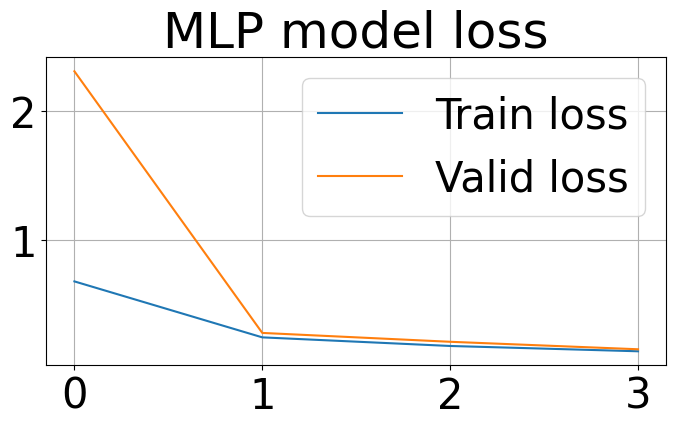

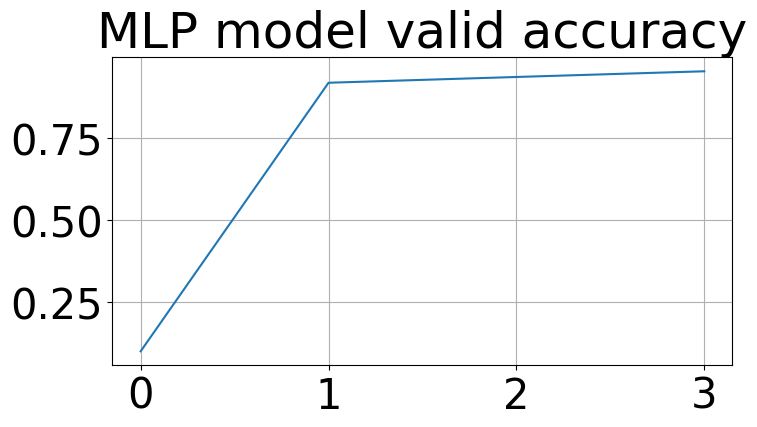

Train:  20%|██        | 12/59 [00:03<00:12,  3.67it/s]


KeyboardInterrupt: 

In [54]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss = train(first_model)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')


valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

## Сверточная сеть

In [57]:
second_model = CustomSequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28 -> 24*24
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #24*24 -> 12*12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5), # 12 - 5 + 1 = 8
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), # 8*8 -> 4*4

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10),
)


x = torch.rand((1, 1, 28, 28))
print(x.shape)
print(second_model(x).shape)

***************************************************************************
Model:
CustomSequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=256, out_features=10, bias=True)
)

Number of parameters: 75194
***************************************************************************
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [58]:
second_model = CustomSequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28 -> 24*24
    nn.BatchNorm2d(16),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=2), #24*24 -> 12*12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5), #12*12 -> 8*8
    nn.BatchNorm2d(16),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), # 8*8 -> 4*4

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=7e-4)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

***************************************************************************
Model:
CustomSequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.2, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=256, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=256, out_features=10, bias=True)
)

Number of parameters: 75258
******************************************************************

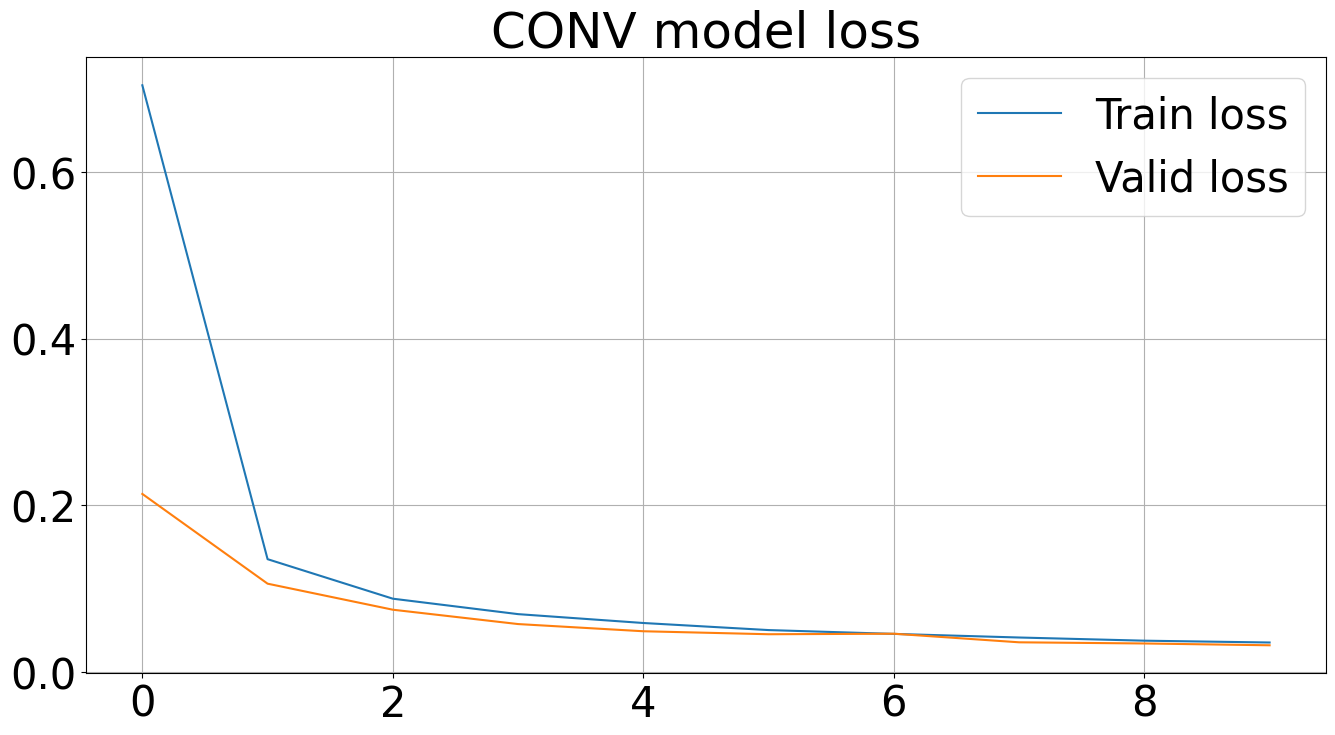

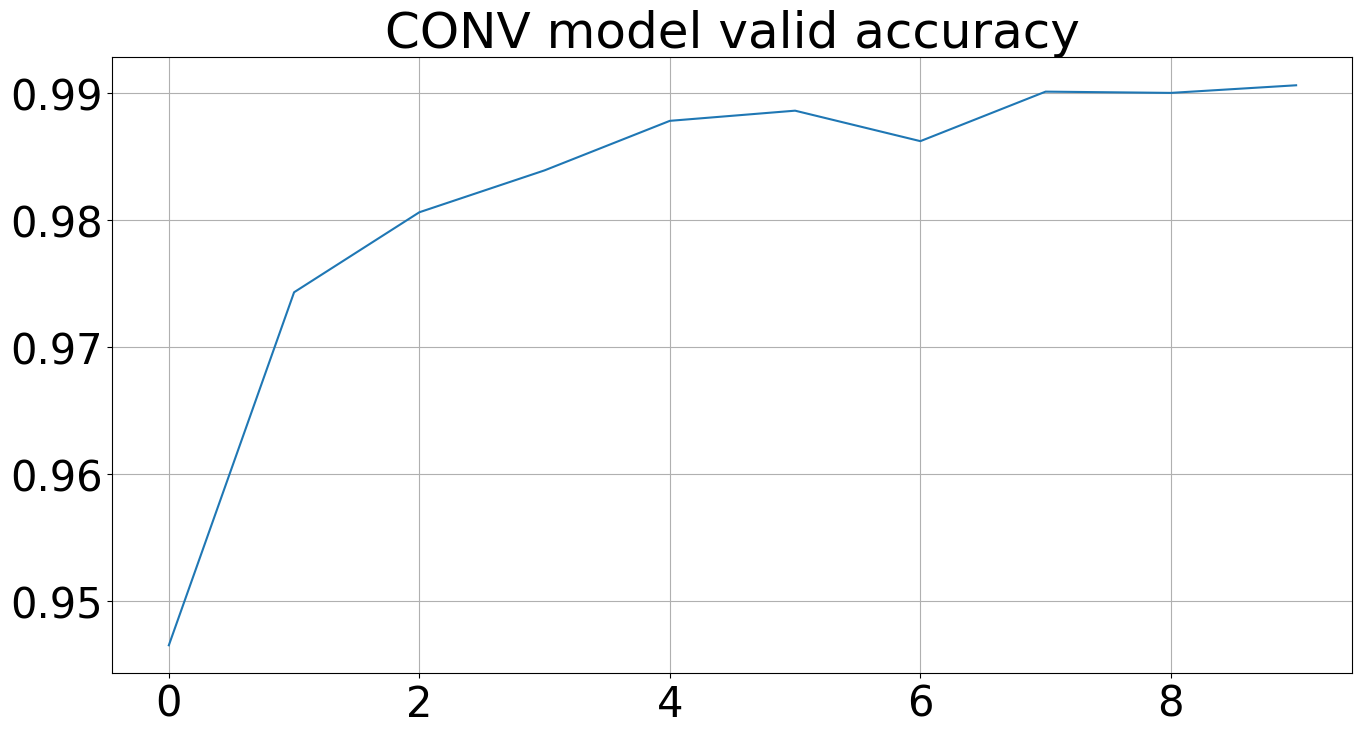

Total training and evaluation time 114.46806


In [59]:
num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [60]:
second_model.eval()

with torch.no_grad():
    for img, cls in valid_loader:
        print("predicted: ", torch.argmax(second_model(img)[:20], dim=-1).cpu())
        print("true:      ", cls[:20], end=f"\n\n{'*' * 80}\n\n")


predicted:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
true:       tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

********************************************************************************

predicted:  tensor([4, 1, 8, 1, 3, 8, 1, 2, 5, 1, 0, 6, 2, 1, 1, 1, 1, 5, 3, 4])
true:       tensor([4, 1, 8, 1, 3, 8, 1, 2, 5, 8, 0, 6, 2, 1, 1, 7, 1, 5, 3, 4])

********************************************************************************

predicted:  tensor([7, 9, 8, 1, 8, 4, 9, 2, 8, 6, 2, 7, 0, 0, 6, 7, 5, 8, 6, 0])
true:       tensor([7, 9, 8, 1, 8, 4, 9, 2, 8, 6, 2, 7, 0, 0, 6, 7, 5, 8, 6, 0])

********************************************************************************

predicted:  tensor([8, 1, 3, 9, 4, 0, 3, 7, 3, 2, 3, 3, 7, 3, 4, 0, 6, 2, 0, 8])
true:       tensor([8, 1, 3, 9, 4, 0, 3, 7, 3, 2, 3, 3, 7, 3, 4, 0, 6, 2, 0, 8])

********************************************************************************

predicted:  tensor([

## Зафигачим обученную модель

(пример адаптирован из https://github.com/mryab/efficient-dl-systems/tree/main)

Можно взять предобученную модель и сразу ей пользоваться, давайте так и сделаем!


Создадим простой http-запрос, который идет по ссылке и качает оттуда картинку, побрабатывает ее и передает нейрокне, которую мы предварительно проинициализировали предобученными весами

Будем получать от нее ответы, какие объекты содержатся на картинке

In [61]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

CATEGORIES = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1.meta['categories']
SCORE_THRESHOLD = 0.75


model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1).to(DEVICE)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 114MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [62]:
import requests

['person']

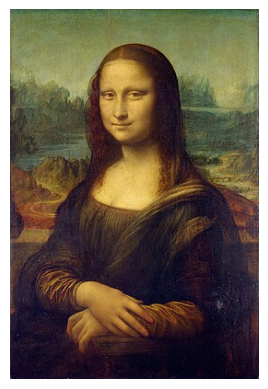

In [65]:
def get_prediction(image_url, model):
    response = requests.get(image_url, stream=True)  # request to the image address, get response
    image = Image.open(response.raw)  # read raw bytes

    # model goes brrr
    image_transformed = T.ToTensor()(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prediction = model(image_transformed)[0]
    labels_predicted = prediction['labels'].data.cpu().numpy()
    scores = prediction['scores'].data.cpu().numpy()

    # get predictions
    labels_selected = labels_predicted[scores > SCORE_THRESHOLD]
    objects = [CATEGORIES[label_id] for label_id in labels_selected]

    # image.show()

    plt.imshow(image)
    plt.axis("off")

    return objects


get_prediction("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", model)

['chair', 'person', 'chair', 'chair', 'chair', 'chair']

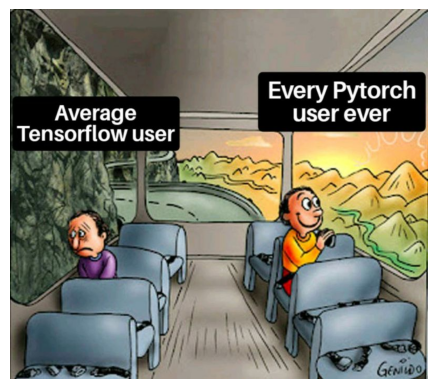

In [66]:
get_prediction("https://media.licdn.com/dms/image/v2/C5622AQEfw4J2wKWv8A/feedshare-shrink_800/feedshare-shrink_800/0/1642765164511?e=2147483647&v=beta&t=2CH5JXpPyOIbF1qCN1eFKTWN16-W38bhIO7l5LP_Mfc", model)

['bird']

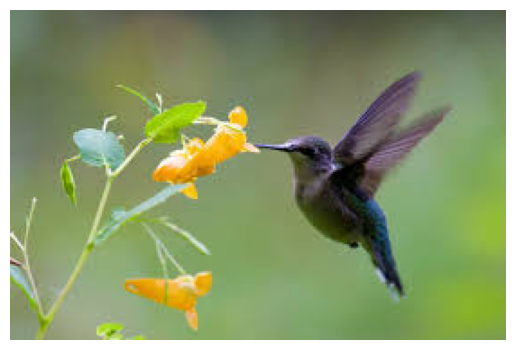

In [67]:
get_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTPMiNrFTdy4vYgOcjhcN6PPqEVB08V3KdQ2A&s", model)

['person', 'person']

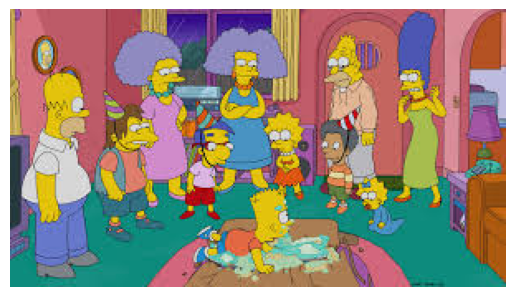

In [68]:
get_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ92tpDktYrkx4camlJR3yUpXI5_ElqdZfKWA&s", model)

['laptop', 'person', 'person', 'train', 'car']

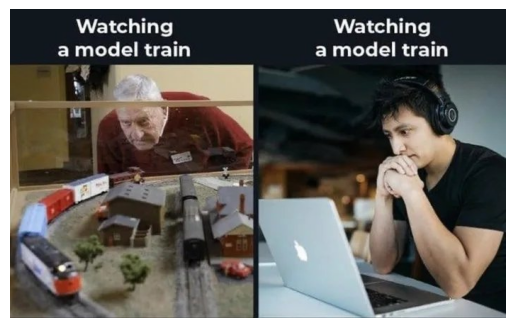

In [69]:
get_prediction("https://i.redd.it/j586af7nxvu41.jpg", model)

torch.Size([1, 3, 272, 492])


['person', 'tie']

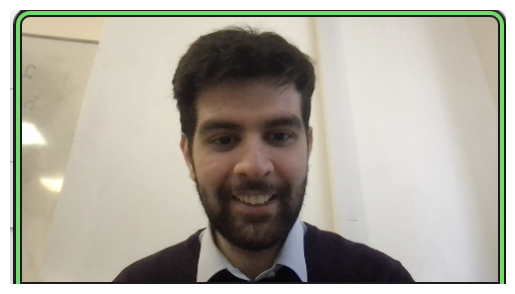

In [77]:
def get_prediction2(image, model):
    # response = requests.get(image_url, stream=True)  # request to the image address, get response
    image = Image.open(image)  # read raw bytes


    # model goes brrr
    image_transformed = T.ToTensor()(image)[0:3,:, :].unsqueeze(0).to(DEVICE)
    print(image_transformed.shape)
    with torch.no_grad():
        prediction = model(image_transformed)[0]
    labels_predicted = prediction['labels'].data.cpu().numpy()
    scores = prediction['scores'].data.cpu().numpy()

    # get predictions
    labels_selected = labels_predicted[scores > SCORE_THRESHOLD]
    objects = [CATEGORIES[label_id] for label_id in labels_selected]

    # image.show()

    plt.imshow(image)
    plt.axis("off")

    return objects

get_prediction2("temp.png", model)